### Temporal Convolutional Network

### Explanation of Key Parameters in the TCN Pipeline

#### 1. `n_components = 0.90`
- **Description**: This is a parameter for **PCA (Principal Component Analysis)**.
- **Meaning**: I am reducing the dataset to **0.90% principal components**, 
---
#### 2. `batch_size = 32`
- **Description**: Number of samples the model processes **at once** during training.
- **Impact**:
  - Smaller batch size → Faster updates, more noise, better generalization.
  - Larger batch size → Smoother updates, slower convergence, higher memory usage.
- **In this setup**: 32 samples are fed into the model at each step.
---
#### 3. `epochs = 100`
- **Description**: Maximum number of times the model will iterate over the entire training dataset.
- **Impact**:
  - More epochs = More chances to learn patterns.
  - Too many epochs = Risk of **overfitting**.
- **Note**: Can be interrupted early by **Early Stopping**.
---
#### 4. `learning_rate = 0.001`
- **Description**: Step size for updating weights in the model.
- **Impact**:
  - Too high → Overshooting good solutions, unstable training.
  - Too low → Slow convergence.
- **In this setup**: A balanced default value used with the **Adam optimizer**.
---
#### 5. `patience = 10`
- **Used With**: **Early Stopping**
- **Description**: Number of epochs to wait for improvement before halting training.
- **Impact**: Prevents unnecessary computation and overfitting by stopping if the model doesn't improve after 10 epochs.
---
#### Summary
> I am reducing the features to 0.90/90% variance using PCA. Then training a neural network using 32 samples at a time, for up to 100 rounds. If it doesn't improve after 10 rounds, training stops early. The learning is done at a moderate pace using a learning rate of 0.001.



In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import psutil
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Data Loading and Preparation ---
# Load your cleaned ETF dataset as before (with all selected features, standardized and ready)

data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
ffeatures = ['returns','RSI_14','Volatility_21','MACD','DMI_minus_14',
             'nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

# Pivot data to wide format with multi-columns per asset-feature
df_wide = pd.DataFrame()
for feat in features:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    df_wide = pd.concat([df_wide, temp], axis=1) if not df_wide.empty else temp
df_wide = df_wide.dropna()

returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

# Select all features except returns
feature_cols = []
for asset in assets:
    for feat in features:
        if feat != 'returns':
            col = f"{asset}_{feat}"
            if col in df_wide.columns:
                feature_cols.append(col)
features_data = df_wide[feature_cols]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_data)

# Convert features to numpy array
features_np = features_data.values  # Should be already standardized externally

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
window_size = 30

# --- 2. Generate dynamic portfolio weights ---
def generate_dynamic_weights(returns_df, window=window_size):
    weights_list = []
    for i in range(len(returns_df) - window):
        window_returns = returns_df.iloc[i:i+window]
        mean_returns = window_returns.mean()
        mean_returns[mean_returns < 0] = 0
        if mean_returns.sum() == 0:
            weights = np.ones(len(mean_returns)) / len(mean_returns)
        else:
            weights = mean_returns / mean_returns.sum()
        weights_list.append(np.array(weights))
    return np.array(weights_list)

dynamic_weights = generate_dynamic_weights(etf_returns, window=window_size)

# # --- 3. Create sequences for model input and targets ---
# def create_sequences(features_data, returns_data, weights_data, window):
#     X, y_sharpe, y_weights = [], [], []
#     limit = len(features_data) - window * 2
#     for i in range(limit):
#         seq_x = features_data[i:i+window]
#         returns_w = returns_data.iloc[i+window:i+window*2]
#         mean_ret = returns_w.mean().mean()
#         std_ret = returns_w.std().mean()
#         sharpe = mean_ret / (std_ret + 1e-6)
#         weight_target = weights_data[i+window] if i+window < len(weights_data) else np.ones(len(assets)) / len(assets)
#         X.append(seq_x)
#         y_sharpe.append(sharpe)
#         y_weights.append(weight_target)
#     return np.array(X), np.array(y_sharpe), np.array(y_weights)

# X, y_sharpe, y_weights = create_sequences(features_np, etf_returns, dynamic_weights, window_size)

# --- 3. Create sequences with clipped and standardized Sharpe targets ---
def standardize_targets(y):
    scaler = StandardScaler()
    y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()
    return y_scaled, scaler

def create_sequences(features_data, returns_data, weights_data, window, clip_sharpe=True):
    X, y_sharpe, y_weights = [], [], []
    limit = len(features_data) - window * 2
    for i in range(limit):
        seq_x = features_data[i:i+window]
        returns_w = returns_data.iloc[i+window:i+window*2]
        mean_ret = returns_w.mean().mean()
        std_ret = returns_w.std().mean()
        sharpe = mean_ret / (std_ret + 1e-6)
        if clip_sharpe:
            sharpe = np.clip(sharpe, -5, 5)
        weight_target = weights_data[i+window] if i+window < len(weights_data) else np.ones(len(assets)) / len(assets)
        X.append(seq_x)
        y_sharpe.append(sharpe)
        y_weights.append(weight_target)
    y_sharpe_arr = np.array(y_sharpe)
    y_sharpe_scaled, scaler = standardize_targets(y_sharpe_arr)
    return np.array(X), y_sharpe_scaled, np.array(y_weights), scaler

X, y_sharpe_scaled, y_weights, sharpe_scaler = create_sequences(features_np, etf_returns, dynamic_weights, window_size)


# --- 4. Dataset and DataLoader ---
class PortfolioDataset(Dataset):
    def __init__(self, X, y_sharpe, y_weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
        self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
    X, y_sharpe, y_weights, test_size=0.2, random_state=42)

train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# --- 5. TCN model definition ---
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.bn1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.bn2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                        dilation=dilation_size, padding=(kernel_size-1)*dilation_size,
                                        dropout=dropout))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        y = self.network(x)
        y = y.permute(0, 2, 1)  # (batch, seq_len, features)
        return y

class TCNPortfolioModel(nn.Module):
    def __init__(self, num_features, n_assets, kernel_size=3, dropout=0.2, num_channels=[64, 64]):
        super().__init__()
        self.tcn = TCN(num_features, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.fc_shared = nn.Linear(num_channels[-1], 128)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
        self.sharpe_out = nn.Linear(128, 1)
        self.weights_out = nn.Linear(128, n_assets)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        y = self.tcn(x)
        last_step = y[:, -1, :]
        feat = self.relu(self.fc_shared(last_step))
        feat = self.drop(feat)
        sharpe = self.sharpe_out(feat)
        weights = self.softmax(self.weights_out(feat))
        return sharpe, weights

model = TCNPortfolioModel(num_features=features_np.shape[1], n_assets=len(assets)).to(device)

criterion_sharpe = nn.MSELoss()
criterion_weights = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 6. Training Loop ---
epochs = 50
model.train()
start_train = time.time()
cpu_start = psutil.cpu_percent(interval=None)

for epoch in range(epochs):
    total_loss = 0
    for batch_x, batch_sharpe, batch_weights in train_loader:
        batch_x, batch_sharpe, batch_weights = batch_x.to(device), batch_sharpe.to(device), batch_weights.to(device)
        optimizer.zero_grad()
        pred_sharpe, pred_weights = model(batch_x)
        loss = criterion_sharpe(pred_sharpe, batch_sharpe) + criterion_weights(pred_weights, batch_weights)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")

train_time = time.time() - start_train
cpu_end = psutil.cpu_percent(interval=None)
cpu_usage = cpu_end - cpu_start

# --- 7. Evaluation ---
model.eval()
all_pred_sharpe = []
all_pred_weights = []
all_true_sharpe = []
all_true_weights = []
with torch.no_grad():
    for batch_x, batch_sharpe, batch_weights in test_loader:
        batch_x = batch_x.to(device)
        pred_sharpe, pred_weights = model(batch_x)
        all_pred_sharpe.append(pred_sharpe.cpu().numpy())
        all_pred_weights.append(pred_weights.cpu().numpy())
        all_true_sharpe.append(batch_sharpe.cpu().numpy())
        all_true_weights.append(batch_weights.cpu().numpy())

pred_sharpe = np.vstack(all_pred_sharpe).flatten()
pred_weights = np.vstack(all_pred_weights)
pred_weights /= pred_weights.sum(axis=1, keepdims=True)
true_sharpe = np.vstack(all_true_sharpe).flatten()
true_weights = np.vstack(all_true_weights)

test_returns = etf_returns.iloc[-len(pred_weights):].values
portfolio_returns = np.sum(test_returns * pred_weights, axis=1)
turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

# # --- Metrics ---
# def sortino_ratio(returns, risk_free=0, periods_per_year=252):
#     returns = pd.Series(returns)
#     downside_returns = returns[returns < risk_free]
#     expected_return = returns.mean() * periods_per_year
#     downside_std = downside_returns.std() * np.sqrt(periods_per_year)
#     return expected_return / downside_std if downside_std != 0 else np.nan

# def calmar_ratio(returns, freq='daily'):
#     returns = pd.Series(returns)
#     periods_per_year = 252 if freq == 'daily' else 12 if freq == 'monthly' else 1
#     cumulative = (1 + returns).cumprod()
#     annualized_return = cumulative.iloc[-1] ** (periods_per_year / len(returns)) - 1
#     max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
#     return annualized_return / max_drawdown if max_drawdown != 0 else np.nan

# Inverse transform Sharpe ratios to original scale
pred_sharpe = sharpe_scaler.inverse_transform(pred_sharpe_scaled.reshape(-1,1)).flatten()
true_sharpe = sharpe_scaler.inverse_transform(true_sharpe_scaled.reshape(-1,1)).flatten()

test_returns = etf_returns.iloc[-len(pred_weights):].values
portfolio_returns = np.sum(test_returns * pred_weights, axis=1)
turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

def sortino_ratio(returns, risk_free=0, periods_per_year=252):
    returns = pd.Series(returns)
    downside_returns = returns[returns < risk_free]
    expected_return = returns.mean() * periods_per_year
    downside_std = downside_returns.std() * np.sqrt(periods_per_year)
    return expected_return / downside_std if downside_std != 0 else np.nan

def calmar_ratio(returns, freq='daily'):
    returns = pd.Series(returns)
    periods_per_year = 252 if freq == 'daily' else 12 if freq == 'monthly' else 1
    cumulative = (1 + returns).cumprod()
    annualized_return = cumulative.iloc[-1] ** (periods_per_year / len(returns)) - 1
    max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
    return annualized_return / max_drawdown if max_drawdown != 0 else np.nan

mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
r2_sharpe = r2_score(true_sharpe, pred_sharpe)
sortino = sortino_ratio(portfolio_returns)
calmar = calmar_ratio(portfolio_returns)

def evaluate_portfolio_performance(portfolio_returns, freq='daily'):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    if len(portfolio_returns) == 0:
        raise ValueError("No valid returns for evaluation.")
    periods_per_year = 252 if freq == 'daily' else 12 if freq == 'monthly' else 1
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_vol = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_vol if annualized_vol != 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Maximum Drawdown': max_drawdown
    }

performance_metrics = evaluate_portfolio_performance(portfolio_returns, freq='daily')

print("\n--- TCN Portfolio Performance ---")
print(f"Training time (s): {train_time:.2f}")
print(f"CPU usage change (%): {cpu_usage:.2f}\n")
for k, v in performance_metrics.items():
    if 'Return' in k or 'Volatility' in k or 'Drawdown' in k:
        print(f"- {k}: {v*100:.2f}%")
    else:
        print(f"- {k}: {v:.4f}")
print(f"- Sortino Ratio: {sortino:.4f}")
print(f"- Calmar Ratio: {calmar:.4f}")
print(f"- Average Turnover: {turnover:.4f}")
print(f"- Sharpe MSE: {mse_sharpe:.6f}")
print(f"- Sharpe MAE: {mae_sharpe:.6f}")
print(f"- Sharpe R2: {r2_sharpe:.4f}")

# Save predicted portfolio weights for further analysis
weights_df = pd.DataFrame(pred_weights, index=etf_returns.index[-len(pred_weights):], columns=assets)
# weights_df.to_csv('tcn_portfolio_weights.csv')
print("Saved TCN portfolio weights to CSV.")


Epoch 1/50, Loss: 72749133051.508774
Epoch 2/50, Loss: 3606749207.578948
Epoch 3/50, Loss: 835916730.947368
Epoch 4/50, Loss: 332007235.719298
Epoch 5/50, Loss: 141926650.245614
Epoch 6/50, Loss: 100352628.666667
Epoch 7/50, Loss: 67520485.456140
Epoch 8/50, Loss: 47138134.614035
Epoch 9/50, Loss: 27903029.921053
Epoch 10/50, Loss: 17342787.175439
Epoch 11/50, Loss: 23122408.710526
Epoch 12/50, Loss: 24937880.317982
Epoch 13/50, Loss: 12505162.817982
Epoch 14/50, Loss: 9167836.663377
Epoch 15/50, Loss: 7769083.859649
Epoch 16/50, Loss: 7810270.518640
Epoch 17/50, Loss: 3163143.925987
Epoch 18/50, Loss: 5060350.009868
Epoch 19/50, Loss: 4367137.180099
Epoch 20/50, Loss: 3456016.635143
Epoch 21/50, Loss: 2860620.616228
Epoch 22/50, Loss: 2793159.283991
Epoch 23/50, Loss: 3256128.833059
Epoch 24/50, Loss: 2986498.245066
Epoch 25/50, Loss: 1676861.006031
Epoch 26/50, Loss: 2366009.229715
Epoch 27/50, Loss: 1719022.603755
Epoch 28/50, Loss: 1762829.362253
Epoch 29/50, Loss: 1540197.936815
E

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import psutil
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# --- 1. Data Loading and Preparation ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14','Calmar_Ratio_21','ATR_14','Open','Close','High',
            'nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

df_wide = pd.DataFrame()
for feat in features:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    df_wide = pd.concat([df_wide, temp], axis=1) if not df_wide.empty else temp
df_wide = df_wide.dropna()

returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

feature_cols = []
for asset in assets:
    for feat in features:
        if feat != 'returns':
            col = f"{asset}_{feat}"
            if col in df_wide.columns:
                feature_cols.append(col)
features_data = df_wide[feature_cols]
features_np = features_data.values  # assumes already standardized externally

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
window_size = 30

# --- 2. Generate dynamic portfolio weights ---
def generate_dynamic_weights(returns_df, window=window_size):
    weights_list = []
    for i in range(len(returns_df) - window):
        window_returns = returns_df.iloc[i:i+window]
        mean_returns = window_returns.mean()
        mean_returns[mean_returns < 0] = 0
        if mean_returns.sum() == 0:
            weights = np.ones(len(mean_returns)) / len(mean_returns)
        else:
            weights = mean_returns / mean_returns.sum()
        weights_list.append(np.array(weights))
    return np.array(weights_list)

dynamic_weights = generate_dynamic_weights(etf_returns, window=window_size)

# --- 3. Create sequences with clipped and standardized Sharpe targets ---
def standardize_targets(y):
    scaler = StandardScaler()
    y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()
    return y_scaled, scaler

def create_sequences(features_data, returns_data, weights_data, window, clip_sharpe=True):
    X, y_sharpe, y_weights = [], [], []
    limit = len(features_data) - window * 2
    for i in range(limit):
        seq_x = features_data[i:i+window]
        returns_w = returns_data.iloc[i+window:i+window*2]
        mean_ret = returns_w.mean().mean()
        std_ret = returns_w.std().mean()
        sharpe = mean_ret / (std_ret + 1e-6)
        if clip_sharpe:
            sharpe = np.clip(sharpe, -5, 5)
        weight_target = weights_data[i+window] if i+window < len(weights_data) else np.ones(len(assets)) / len(assets)
        X.append(seq_x)
        y_sharpe.append(sharpe)
        y_weights.append(weight_target)
    y_sharpe_arr = np.array(y_sharpe)
    y_sharpe_scaled, scaler = standardize_targets(y_sharpe_arr)
    return np.array(X), y_sharpe_scaled, np.array(y_weights), scaler

X, y_sharpe_scaled, y_weights, sharpe_scaler = create_sequences(features_np, etf_returns, dynamic_weights, window_size)

# --- 4. Dataset and DataLoader ---
class PortfolioDataset(Dataset):
    def __init__(self, X, y_sharpe, y_weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
        self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
    X, y_sharpe_scaled, y_weights, test_size=0.2, random_state=42)

train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# --- 5. Model definition ---
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.bn1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.bn2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)
class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                        dilation=dilation_size, padding=(kernel_size-1)*dilation_size,
                                        dropout=dropout))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        y = self.network(x)
        y = y.permute(0, 2, 1)
        return y
class TCNPortfolioModel(nn.Module):
    def __init__(self, num_features, n_assets, kernel_size=3, dropout=0.2, num_channels=[64, 64]):
        super().__init__()
        self.tcn = TCN(num_features, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.fc_shared = nn.Linear(num_channels[-1], 128)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
        self.sharpe_out = nn.Linear(128, 1)
        self.weights_out = nn.Linear(128, n_assets)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        y = self.tcn(x)
        last_step = y[:, -1, :]
        feat = self.relu(self.fc_shared(last_step))
        feat = self.drop(feat)
        sharpe = self.sharpe_out(feat)
        weights = self.softmax(self.weights_out(feat))
        return sharpe, weights

model = TCNPortfolioModel(num_features=features_np.shape[1], n_assets=len(assets)).to(device)

criterion_sharpe = nn.MSELoss()
criterion_weights = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 6. Training Loop ---
epochs = 50
model.train()
start_train = time.time()
cpu_start = psutil.cpu_percent(interval=None)
for epoch in range(epochs):
    total_loss = 0
    for batch_x, batch_sharpe, batch_weights in train_loader:
        batch_x, batch_sharpe, batch_weights = batch_x.to(device), batch_sharpe.to(device), batch_weights.to(device)
        optimizer.zero_grad()
        pred_sharpe, pred_weights = model(batch_x)
        loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
        loss_weights = criterion_weights(pred_weights, batch_weights)
        # Weight Sharpe loss lower to stabilize training
        loss = loss_sharpe * 0.1 + loss_weights * 1.0
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")
train_time = time.time() - start_train
cpu_end = psutil.cpu_percent(interval=None)
cpu_usage = cpu_end - cpu_start

# --- 7. Evaluation ---
model.eval()
all_pred_sharpe = []
all_pred_weights = []
all_true_sharpe = []
all_true_weights = []
with torch.no_grad():
    for batch_x, batch_sharpe, batch_weights in test_loader:
        batch_x = batch_x.to(device)
        pred_sharpe, pred_weights = model(batch_x)
        all_pred_sharpe.append(pred_sharpe.cpu().numpy())
        all_pred_weights.append(pred_weights.cpu().numpy())
        all_true_sharpe.append(batch_sharpe.cpu().numpy())
        all_true_weights.append(batch_weights.cpu().numpy())

pred_sharpe_scaled = np.vstack(all_pred_sharpe).flatten()
pred_weights = np.vstack(all_pred_weights)
pred_weights /= pred_weights.sum(axis=1, keepdims=True)
true_sharpe_scaled = np.vstack(all_true_sharpe).flatten()
true_weights = np.vstack(all_true_weights)

# Inverse transform Sharpe ratios to original scale
pred_sharpe = sharpe_scaler.inverse_transform(pred_sharpe_scaled.reshape(-1,1)).flatten()
true_sharpe = sharpe_scaler.inverse_transform(true_sharpe_scaled.reshape(-1,1)).flatten()

test_returns = etf_returns.iloc[-len(pred_weights):].values
portfolio_returns = np.sum(test_returns * pred_weights, axis=1)
turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

def sortino_ratio(returns, risk_free=0, periods_per_year=252):
    returns = pd.Series(returns)
    downside_returns = returns[returns < risk_free]
    expected_return = returns.mean() * periods_per_year
    downside_std = downside_returns.std() * np.sqrt(periods_per_year)
    return expected_return / downside_std if downside_std != 0 else np.nan

def calmar_ratio(returns, freq='daily'):
    returns = pd.Series(returns)
    periods_per_year = 252 if freq == 'daily' else 12 if freq == 'monthly' else 1
    cumulative = (1 + returns).cumprod()
    annualized_return = cumulative.iloc[-1] ** (periods_per_year / len(returns)) - 1
    max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
    return annualized_return / max_drawdown if max_drawdown != 0 else np.nan

mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
r2_sharpe = r2_score(true_sharpe, pred_sharpe)
sortino = sortino_ratio(portfolio_returns)
calmar = calmar_ratio(portfolio_returns)

def evaluate_portfolio_performance(portfolio_returns, freq='daily'):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    if len(portfolio_returns) == 0:
        raise ValueError("No valid returns for evaluation.")
    periods_per_year = 252 if freq == 'daily' else 12 if freq == 'monthly' else 1
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_vol = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_vol if annualized_vol != 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Maximum Drawdown': max_drawdown
    }

performance_metrics = evaluate_portfolio_performance(portfolio_returns, freq='daily')

print("\n--- Modified TCN Portfolio Performance ---")
print(f"Training time (s): {train_time:.2f}")
print(f"CPU usage change (%): {cpu_usage:.2f}\n")
for k, v in performance_metrics.items():
    if "Return" in k or "Volatility" in k or "Drawdown" in k:
        print(f"- {k}: {v*100:.2f}%")
    else:
        print(f"- {k}: {v:.4f}")
print(f"- Sortino Ratio: {sortino:.4f}")
print(f"- Calmar Ratio: {calmar:.4f}")
print(f"- Average Turnover: {turnover:.4f}")
print(f"- Sharpe MSE: {mse_sharpe:.6f}")
print(f"- Sharpe MAE: {mae_sharpe:.6f}")
print(f"- Sharpe R2: {r2_sharpe:.4f}")

weights_df = pd.DataFrame(pred_weights, index=etf_returns.index[-len(pred_weights):], columns=assets)
# weights_df.to_csv('modified_tcn_portfolio_weights.csv')
print("Saved modified TCN portfolio weights to CSV.")


Epoch 1/50, Loss: 10322173172.771931
Epoch 2/50, Loss: 960210702.596491
Epoch 3/50, Loss: 288819320.842105
Epoch 4/50, Loss: 123387165.333333
Epoch 5/50, Loss: 52342645.543860
Epoch 6/50, Loss: 30515749.666667
Epoch 7/50, Loss: 15427069.666667
Epoch 8/50, Loss: 9134739.815789
Epoch 9/50, Loss: 5438803.260965
Epoch 10/50, Loss: 3420672.402412
Epoch 11/50, Loss: 1999010.992873
Epoch 12/50, Loss: 1522518.348136
Epoch 13/50, Loss: 810339.593613
Epoch 14/50, Loss: 568082.228893
Epoch 15/50, Loss: 499313.075726
Epoch 16/50, Loss: 339008.764666
Epoch 17/50, Loss: 278814.813014
Epoch 18/50, Loss: 203972.948842
Epoch 19/50, Loss: 231565.649328
Epoch 20/50, Loss: 127870.701986
Epoch 21/50, Loss: 125692.006973
Epoch 22/50, Loss: 129649.992642
Epoch 23/50, Loss: 56592.416375
Epoch 24/50, Loss: 71039.739986
Epoch 25/50, Loss: 48770.274380
Epoch 26/50, Loss: 46000.748432
Epoch 27/50, Loss: 47868.703307
Epoch 28/50, Loss: 41123.901997
Epoch 29/50, Loss: 33352.376598
Epoch 30/50, Loss: 31782.540097
Ep

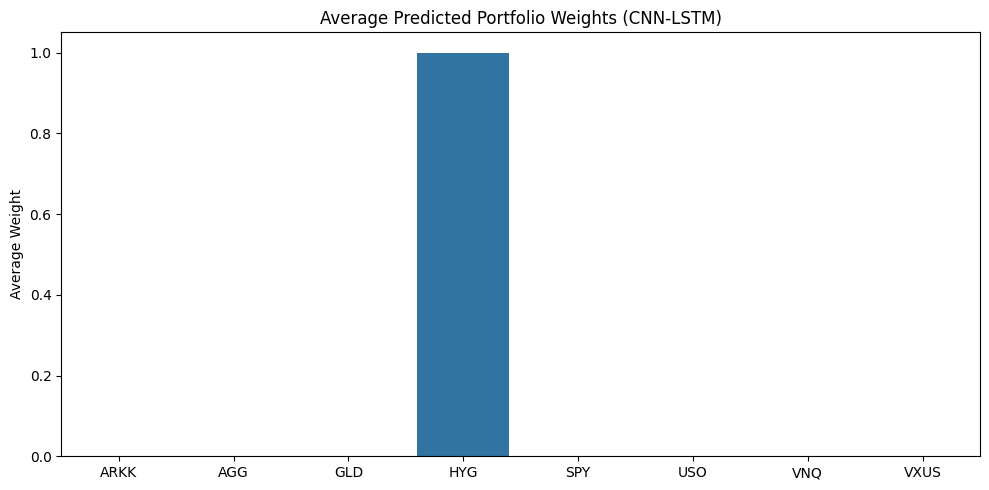

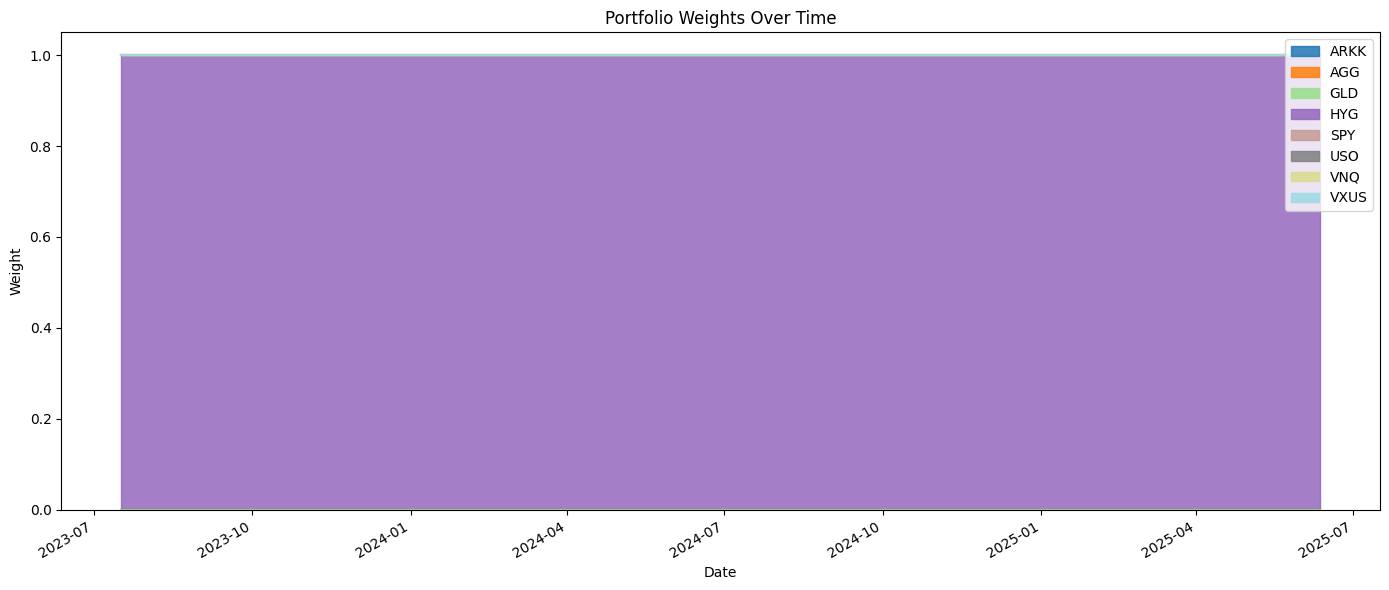

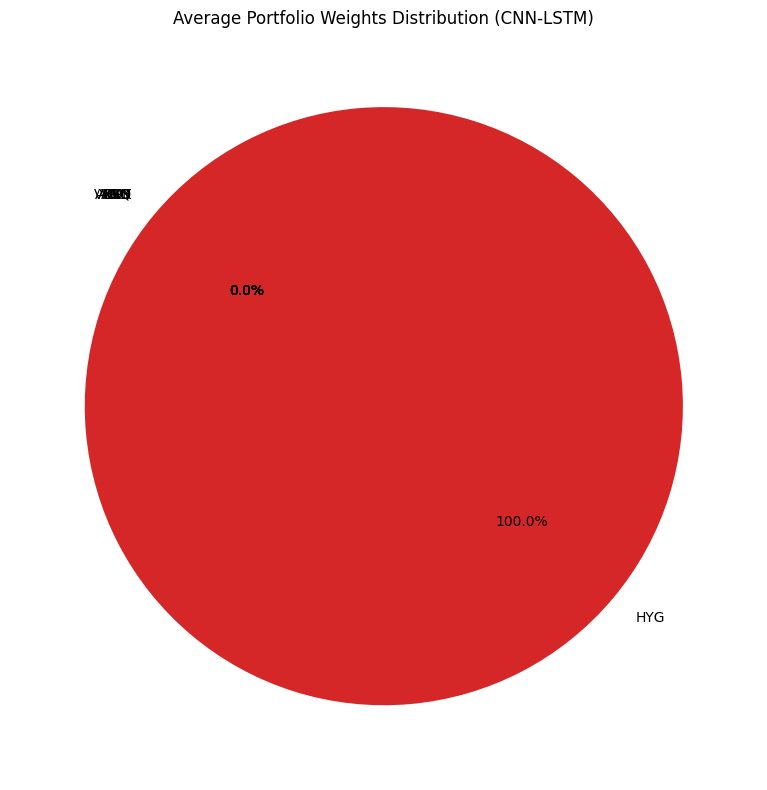

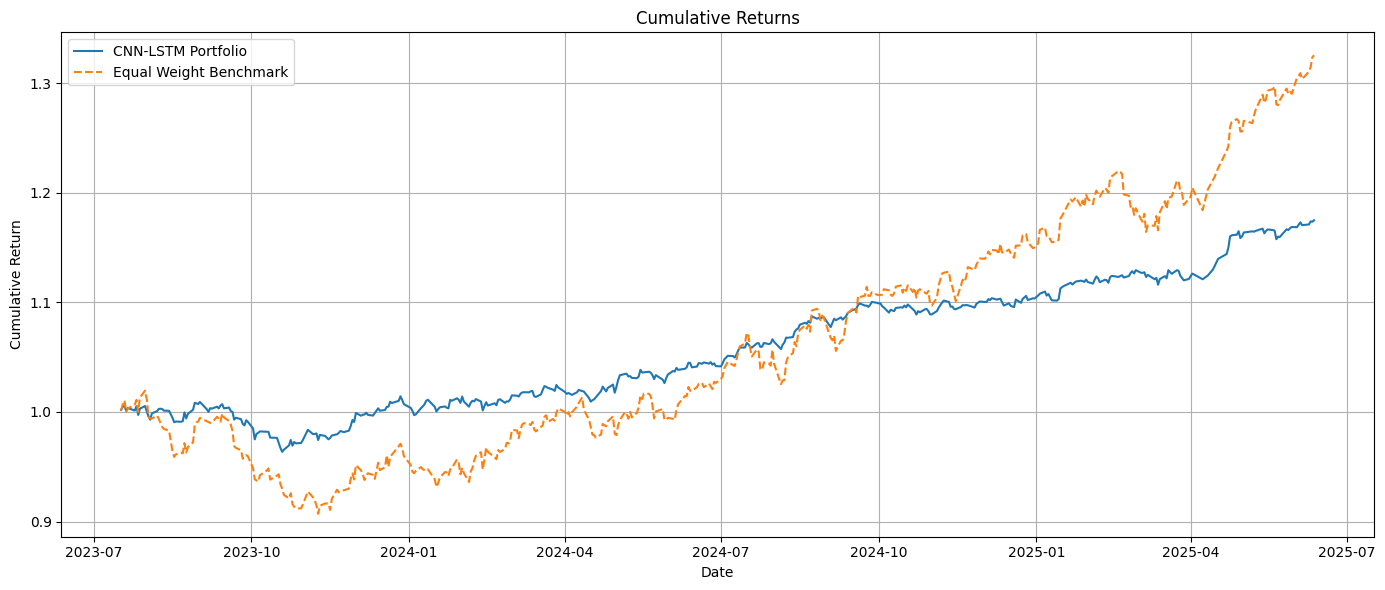

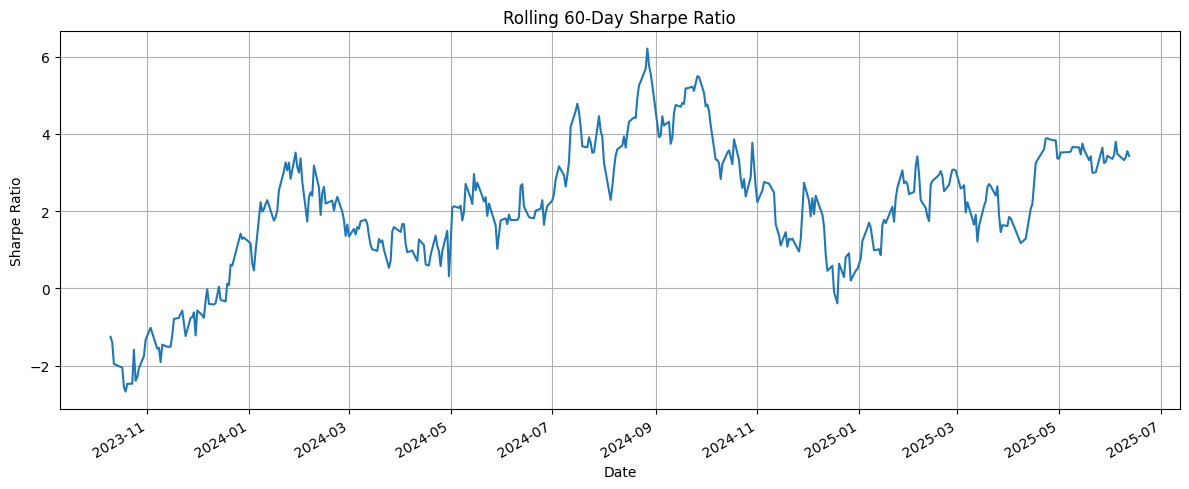

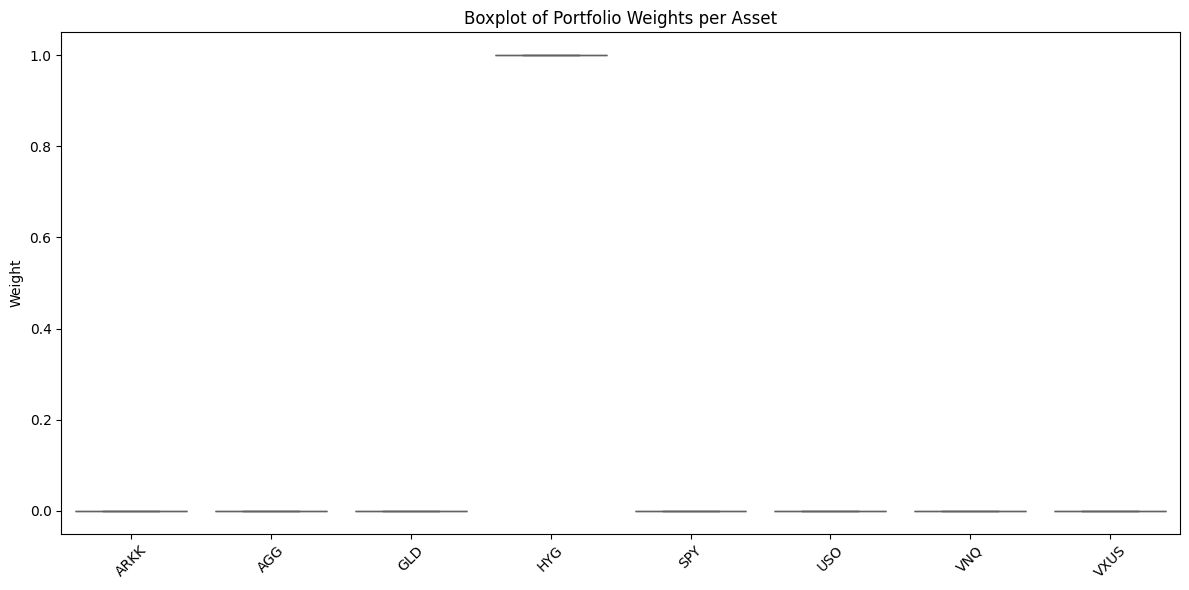

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


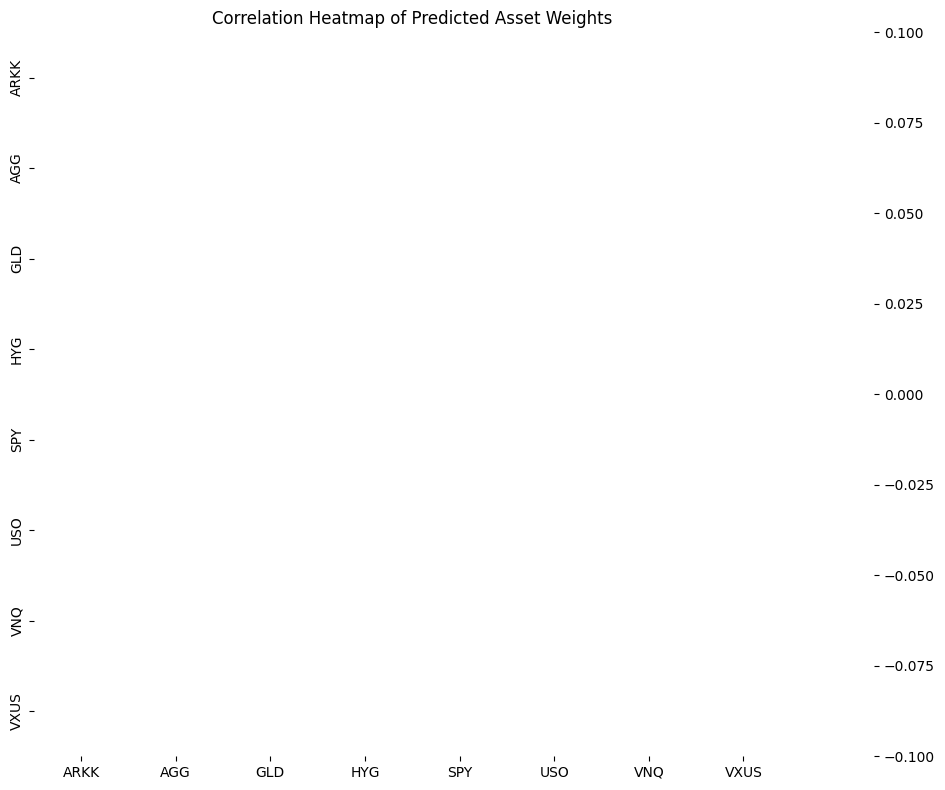

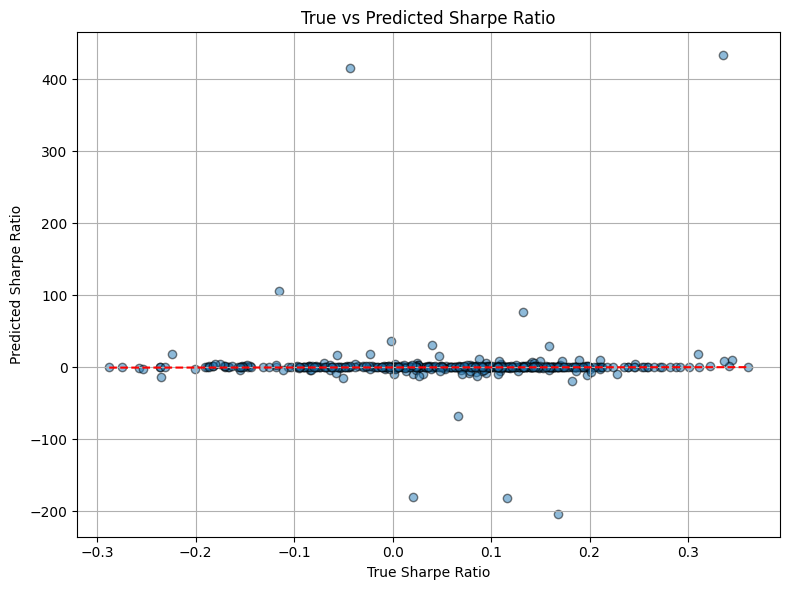

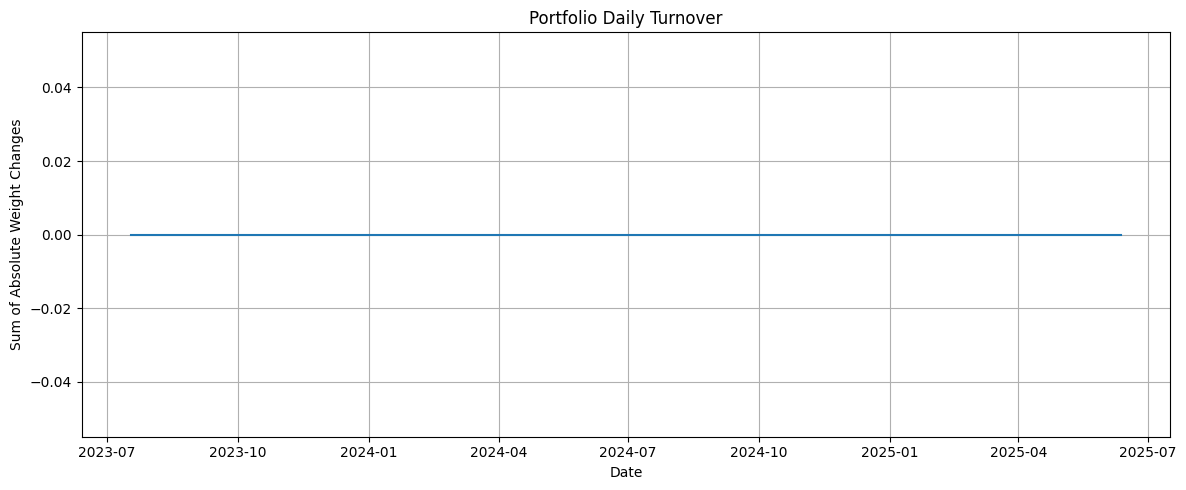

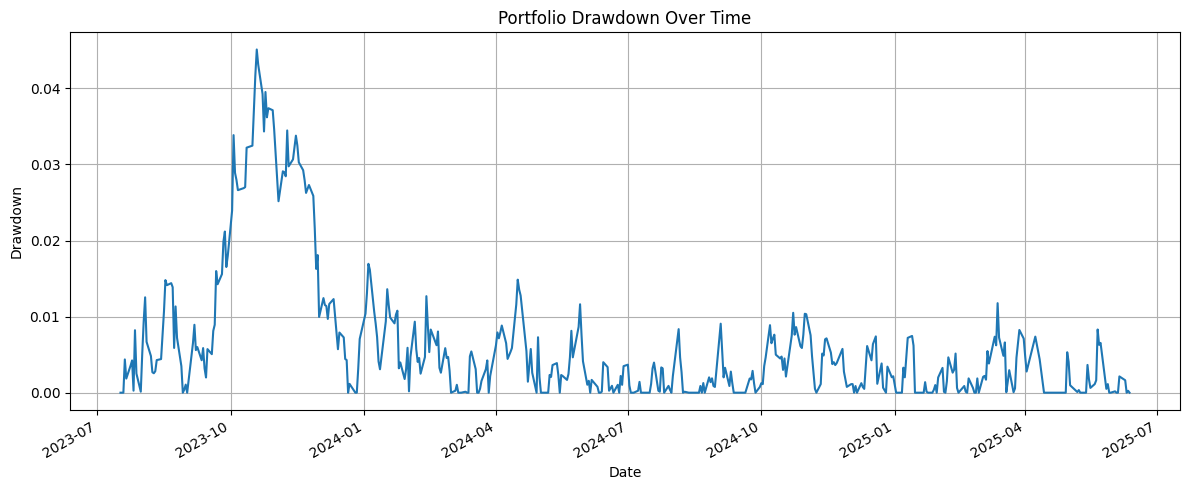

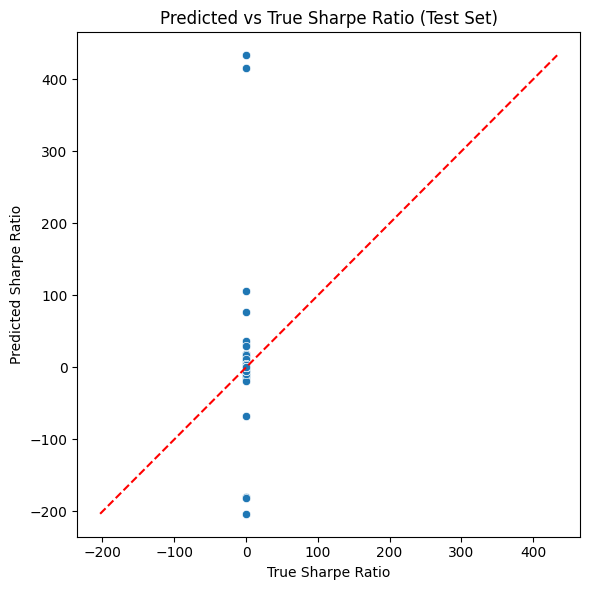

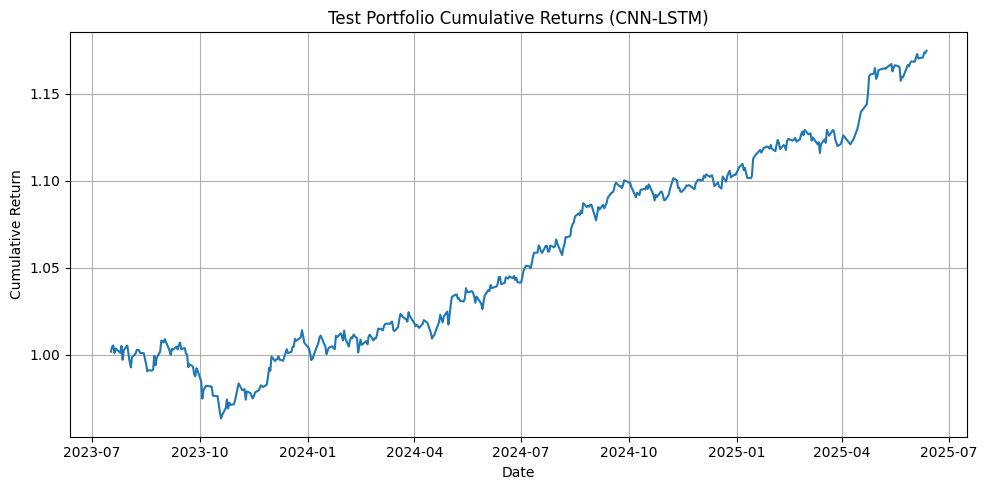

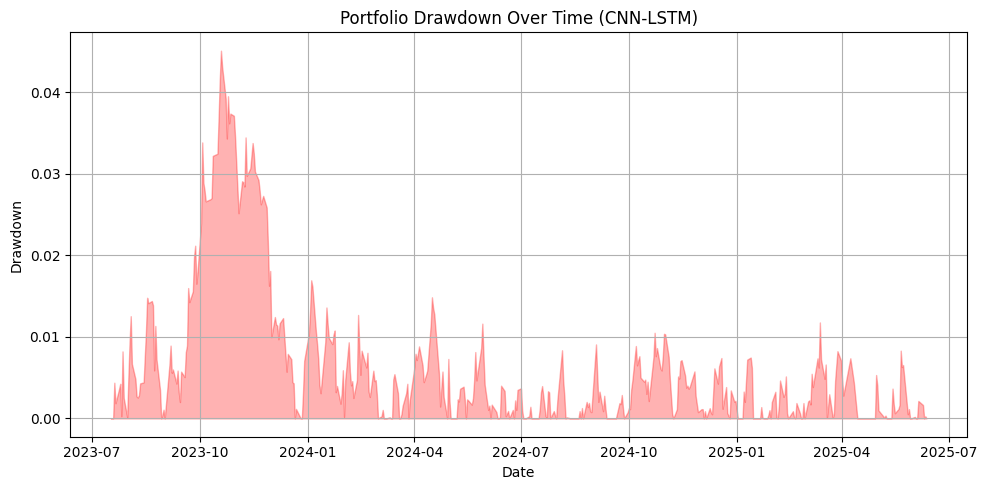

/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_71761/798328053.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='muted')


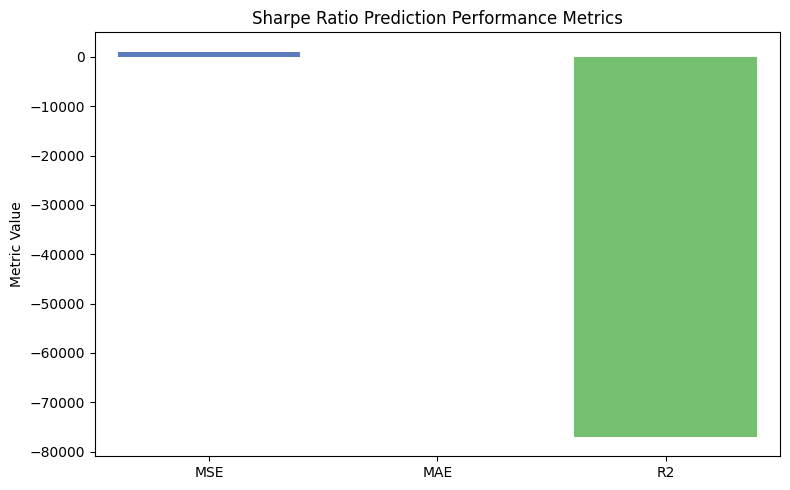

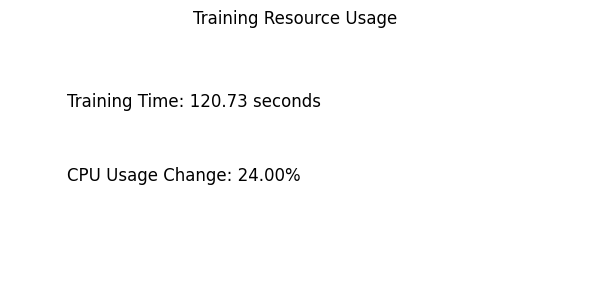

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# assuming the following variables are defined from your CNN-LSTM model and data:
# pred_weights (np.array): predicted portfolio weights, shape (time_steps, n_assets)
# true_sharpe (np.array): true Sharpe ratios for test samples
# pred_sharpe (np.array): predicted Sharpe ratios for test samples
# etf_returns (pd.DataFrame): aligned returns data for test period, shape (time_steps, n_assets)
# assets (list of str): asset tickers or names

# 1. Average Predicted Portfolio Weights (Bar Plot)
avg_weights = pred_weights.mean(axis=0)
plt.figure(figsize=(10,5))
sns.barplot(x=assets, y=avg_weights)
plt.title('Average Predicted Portfolio Weights (CNN-LSTM)')
plt.ylabel('Average Weight')
plt.tight_layout()
plt.show()

# # 1. Pie Chart: Average Portfolio Allocation
# avg_weights = pred_weights.mean(axis=0)
# plt.figure(figsize=(8, 8))
# plt.pie(avg_weights, labels=assets, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
# plt.title('Average Portfolio Allocation Across Test Period')
# plt.tight_layout()
# plt.show()

# 2. Stacked Area Chart: Portfolio Weights Over Time
pred_weights = pd.DataFrame(pred_weights, columns=assets, index=etf_returns.index[-len(pred_weights):])
pred_weights.plot.area(figsize=(14,6), cmap='tab20', alpha=0.85)
plt.title('Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# # 2. Portfolio Weights Over Time (Line Plot)
# plt.figure(figsize=(12,6))
# for asset in assets:
#     plt.plot(pred_weights.index, pred_weights[asset], label=asset)
# plt.title('Portfolio Weights Over Time (CNN-LSTM)')
# plt.xlabel('Date')
# plt.ylabel('Weight')
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# 3. Pie Chart of Average Portfolio Weights
plt.figure(figsize=(8,8))
plt.pie(avg_weights, labels=assets, autopct='%1.1f%%', startangle=140)
plt.title('Average Portfolio Weights Distribution (CNN-LSTM)')
plt.tight_layout()
plt.show()

# 3. Cumulative Returns of Portfolio vs Equal Weight Benchmark
portfolio_returns = np.sum(pred_weights * etf_returns.iloc[-len(pred_weights):].values, axis=1)
cumulative_portfolio = (1 + pd.Series(portfolio_returns, index=weights_df.index)).cumprod()

equal_weight_returns = etf_returns.iloc[-len(pred_weights):].mean(axis=1)
cumulative_equal = (1 + equal_weight_returns).cumprod()

plt.figure(figsize=(14,6))
plt.plot(cumulative_portfolio, label='CNN-LSTM Portfolio')
plt.plot(cumulative_equal, label='Equal Weight Benchmark', linestyle='--')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Rolling Sharpe Ratio (60-day window)
rolling_window = 60
rolling_returns = pd.Series(portfolio_returns, index=weights_df.index).rolling(rolling_window)
rolling_sharpe = rolling_returns.mean() / (rolling_returns.std() + 1e-6) * np.sqrt(252)

plt.figure(figsize=(12,5))
rolling_sharpe.plot()
plt.title(f'Rolling {rolling_window}-Day Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

# # 5. Histogram: Distribution of All Portfolio Weights
# plt.figure(figsize=(10,6))
# sns.histplot(pred_weights.flatten(), bins=50, kde=True, color='skyblue')
# plt.title('Distribution of Portfolio Weights')
# plt.xlabel('Weight')
# plt.ylabel('Frequency')
# plt.tight_layout()
# plt.show()

# 6. Boxplot: Portfolio Weights Per Asset
plt.figure(figsize=(12,6))
sns.boxplot(data=weights_df, palette='Set3')
plt.title('Boxplot of Portfolio Weights per Asset')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Correlation Heatmap: Asset Weights Correlation
plt.figure(figsize=(10,8))
corr_weights = weights_df.corr()
sns.heatmap(corr_weights, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Predicted Asset Weights')
plt.tight_layout()
plt.show()

# 8. Scatter Plot: True vs Predicted Sharpe Ratios
plt.figure(figsize=(8,6))
plt.scatter(true_sharpe, pred_sharpe, alpha=0.5, edgecolors='k')
plt.plot([true_sharpe.min(), true_sharpe.max()], [true_sharpe.min(), true_sharpe.max()], 'r--')
plt.xlabel('True Sharpe Ratio')
plt.ylabel('Predicted Sharpe Ratio')
plt.title('True vs Predicted Sharpe Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Daily Portfolio Turnover Over Time
turnover = np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1)
plt.figure(figsize=(12,5))
plt.plot(weights_df.index[1:], turnover)
plt.title('Portfolio Daily Turnover')
plt.xlabel('Date')
plt.ylabel('Sum of Absolute Weight Changes')
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Drawdown Curve
cum_returns = (1 + pd.Series(portfolio_returns, index=weights_df.index)).cumprod()
rolling_max = cum_returns.cummax()
drawdown = (rolling_max - cum_returns) / rolling_max

plt.figure(figsize=(12,5))
drawdown.plot()
plt.title('Portfolio Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Predicted vs True Sharpe Ratio Scatter Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=true_sharpe, y=pred_sharpe)
min_val = min(min(true_sharpe), min(pred_sharpe))
max_val = max(max(true_sharpe), max(pred_sharpe))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Predicted vs True Sharpe Ratio (Test Set)')
plt.xlabel('True Sharpe Ratio')
plt.ylabel('Predicted Sharpe Ratio')
plt.tight_layout()
plt.show()

# 5. Portfolio Cumulative Returns (Test Set)
cum_returns = (1 + pd.Series(portfolio_returns, index=weights_df.index)).cumprod()
plt.figure(figsize=(10,5))
plt.plot(cum_returns.index, cum_returns.values)
plt.title('Test Portfolio Cumulative Returns (CNN-LSTM)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Portfolio Drawdown Plot
peak = cum_returns.cummax()
drawdown = (peak - cum_returns) / peak
plt.figure(figsize=(10,5))
plt.fill_between(drawdown.index, drawdown.values, color='red', alpha=0.3)
plt.title('Portfolio Drawdown Over Time (CNN-LSTM)')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# # 7. Heatmap of ETF Allocations Over Time
# plt.figure(figsize=(12,6))
# sns.heatmap(weights_df.T, xticklabels=weights_df.index.strftime('%Y-%m-%d'), yticklabels=assets, cmap='viridis')
# plt.title('Heatmap of ETF Allocation Over Time (CNN-LSTM)')
# plt.xlabel('Date')
# plt.ylabel('ETF')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# 2. Bar Plot of Performance Metrics (MSE, MAE, R²)
metrics = ['MSE', 'MAE', 'R2']
values = [mse_sharpe, mae_sharpe, r2_sharpe]

plt.figure(figsize=(8,5))
sns.barplot(x=metrics, y=values, palette='muted')
plt.title('Sharpe Ratio Prediction Performance Metrics')
plt.ylabel('Metric Value')
plt.tight_layout()
plt.show()

# 3. Display Training Time and CPU Usage as Text Plot
plt.figure(figsize=(6,3))
plt.axis('off')
plt.text(0.1, 0.7, f'Training Time: {train_time:.2f} seconds', fontsize=12)
plt.text(0.1, 0.4, f'CPU Usage Change: {cpu_usage:.2f}%', fontsize=12)
plt.title('Training Resource Usage')
plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import psutil
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# --- 1. Data Loading and Preparation ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14','Calmar_Ratio_21','ATR_14','Open','Close','High',
            'nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

df_wide = pd.DataFrame()
for feat in features:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    df_wide = pd.concat([df_wide, temp], axis=1) if not df_wide.empty else temp
df_wide = df_wide.dropna()

returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

feature_cols = []
for asset in assets:
    for feat in features:
        if feat != 'returns':
            col = f"{asset}_{feat}"
            if col in df_wide.columns:
                feature_cols.append(col)
features_data = df_wide[feature_cols]
features_np = features_data.values  # assumes already standardized externally

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
window_size = 30

# --- 2. Risk parity weight generator ---
def risk_parity_weights(returns_window):
    cov = np.cov(returns_window.T)
    vol = np.sqrt(np.diag(cov))
    inv_vol = 1.0 / (vol + 1e-8)
    weights = inv_vol / inv_vol.sum()
    return weights

def generate_dynamic_weights_with_risk(returns_df, window=window_size):
    weights_list = []
    for i in range(len(returns_df) - window):
        window_returns = returns_df.iloc[i:i+window].values
        weights = risk_parity_weights(window_returns)
        weights_list.append(weights)
    return np.array(weights_list)

dynamic_weights = generate_dynamic_weights_with_risk(etf_returns, window=window_size)

# --- 3. Sequence creation with Sharpe ratio target (clipped and scaled) ---
def standardize_targets(y):
    scaler = StandardScaler()
    y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()
    return y_scaled, scaler

def create_sequences(features_data, returns_data, weights_data, window, clip_sharpe=True):
    X, y_sharpe, y_weights = [], [], []
    limit = len(features_data) - 2*window
    for i in range(limit):
        seq_x = features_data[i:i+window]
        returns_w = returns_data.iloc[i+window:i+2*window]
        mean_ret = returns_w.mean().mean()
        std_ret = returns_w.std().mean()
        sharpe = mean_ret / (std_ret + 1e-6)
        if clip_sharpe:
            sharpe = np.clip(sharpe, -5, 5)
        # Align weights_data indices with constructed sequences
        weight_target = weights_data[i] if i < len(weights_data) else np.ones(len(assets))/len(assets)
        X.append(seq_x)
        y_sharpe.append(sharpe)
        y_weights.append(weight_target)
    y_sharpe_arr = np.array(y_sharpe)
    y_sharpe_scaled, scaler = standardize_targets(y_sharpe_arr)
    return np.array(X), y_sharpe_scaled, np.array(y_weights), scaler

X, y_sharpe_scaled, y_weights, sharpe_scaler = create_sequences(features_np, etf_returns, dynamic_weights, window_size)

# --- 4. Dataset and DataLoader ---
class PortfolioDataset(Dataset):
    def __init__(self, X, y_sharpe, y_weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
        self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
    X, y_sharpe_scaled, y_weights, test_size=0.2, random_state=42)

train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# --- 5. TCN model ---
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.bn1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.bn2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                        dilation=dilation_size, padding=(kernel_size-1)*dilation_size,
                                        dropout=dropout))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        y = self.network(x)
        y = y.permute(0, 2, 1)  # (batch, seq_len, features)
        return y

class TCNPortfolioModel(nn.Module):
    def __init__(self, num_features, n_assets, kernel_size=3, dropout=0.2, num_channels=[64,64]):
        super().__init__()
        self.tcn = TCN(num_features, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.fc_shared = nn.Linear(num_channels[-1], 128)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
        self.sharpe_out = nn.Linear(128, 1)
        self.weights_out = nn.Linear(128, n_assets)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        y = self.tcn(x)
        last_step = y[:, -1, :]
        feat = self.relu(self.fc_shared(last_step))
        feat = self.drop(feat)
        sharpe = self.sharpe_out(feat)
        weights_raw = self.weights_out(feat)
        weights = self.softmax(weights_raw)
        return sharpe, weights

model = TCNPortfolioModel(num_features=features_np.shape[1], n_assets=len(assets)).to(device)

criterion_sharpe = nn.MSELoss()
criterion_weights = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 6. Training Loop ---
epochs = 50
model.train()
start_train = time.time()
cpu_start = psutil.cpu_percent(interval=None)
for epoch in range(epochs):
    total_loss = 0
    for batch_x, batch_sharpe, batch_weights in train_loader:
        batch_x, batch_sharpe, batch_weights = batch_x.to(device), batch_sharpe.to(device), batch_weights.to(device)
        optimizer.zero_grad()
        pred_sharpe, pred_weights = model(batch_x)
        loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
        loss_weights = criterion_weights(pred_weights, batch_weights)
        loss = loss_sharpe * 0.1 + loss_weights  # Weighted loss to prioritize weights
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")
train_time = time.time() - start_train
cpu_end = psutil.cpu_percent(interval=None)
cpu_usage = cpu_end - cpu_start

# --- 7. Evaluation ---
model.eval()
all_pred_sharpe = []
all_true_sharpe = []
all_pred_weights = []
all_true_weights = []
with torch.no_grad():
    for batch_x, batch_sharpe, batch_weights in test_loader:
        batch_x = batch_x.to(device)
        pred_sharpe, pred_weights = model(batch_x)
        all_pred_sharpe.append(pred_sharpe.cpu().numpy())
        all_pred_weights.append(pred_weights.cpu().numpy())
        all_true_sharpe.append(batch_sharpe.cpu().numpy())
        all_true_weights.append(batch_weights.cpu().numpy())
pred_sharpe_scaled = np.vstack(all_pred_sharpe).flatten()
true_sharpe_scaled = np.vstack(all_true_sharpe).flatten()
pred_weights = np.vstack(all_pred_weights)
pred_weights /= pred_weights.sum(axis=1, keepdims=True)
true_weights = np.vstack(all_true_weights)
# Inverse transform Sharpe ratios
pred_sharpe = sharpe_scaler.inverse_transform(pred_sharpe_scaled.reshape(-1,1)).flatten()
true_sharpe = sharpe_scaler.inverse_transform(true_sharpe_scaled.reshape(-1,1)).flatten()
test_returns = etf_returns.iloc[-len(pred_weights):].values
portfolio_returns = np.sum(test_returns * pred_weights, axis=1)
turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

def sortino_ratio(returns, risk_free=0, periods_per_year=252):
    returns = pd.Series(returns)
    downside_returns = returns[returns < risk_free]
    expected_return = returns.mean() * periods_per_year
    downside_std = downside_returns.std() * np.sqrt(periods_per_year)
    return expected_return / downside_std if downside_std != 0 else np.nan

def calmar_ratio(returns, freq='daily'):
    returns = pd.Series(returns)
    periods_per_year = 252 if freq == 'daily' else 12 if freq == 'monthly' else 1
    cumulative = (1 + returns).cumprod()
    annualized_return = cumulative.iloc[-1] ** (periods_per_year / len(returns)) - 1
    max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
    return annualized_return / max_drawdown if max_drawdown != 0 else np.nan

mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
r2_sharpe = r2_score(true_sharpe, pred_sharpe)
sortino = sortino_ratio(portfolio_returns)
calmar = calmar_ratio(portfolio_returns)

def evaluate_portfolio_performance(portfolio_returns, freq='daily'):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    if len(portfolio_returns) == 0:
        raise ValueError("No valid returns for evaluation.")
    periods_per_year = 252 if freq == 'daily' else 12 if freq == 'monthly' else 1
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_vol = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_vol if annualized_vol != 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Maximum Drawdown': max_drawdown
    }

performance_metrics = evaluate_portfolio_performance(portfolio_returns, freq='daily')

print("\n--- Modified TCN Portfolio Performance ---")
print(f"Training time (s): {train_time:.2f}")
print(f"CPU usage change (%): {cpu_usage:.2f}\n")
for k, v in performance_metrics.items():
    if "Return" in k or "Volatility" in k or "Drawdown" in k:
        print(f"- {k}: {v*100:.2f}%")
    else:
        print(f"- {k}: {v:.4f}")
print(f"- Sortino Ratio: {sortino:.4f}")
print(f"- Calmar Ratio: {calmar:.4f}")
print(f"- Average Turnover: {turnover:.4f}")
print(f"- Sharpe MSE: {mse_sharpe:.6f}")
print(f"- Sharpe MAE: {mae_sharpe:.6f}")
print(f"- Sharpe R2: {r2_sharpe:.4f}")

weights_df = pd.DataFrame(pred_weights, index=etf_returns.index[-len(pred_weights):], columns=assets)
# weights_df.to_csv('modified_tcn_portfolio_weights.csv')
print("Saved modified TCN portfolio weights to CSV.")


Epoch 1/50, Loss: 5142319498.666667
Epoch 2/50, Loss: 342970672.000000
Epoch 3/50, Loss: 94513363.614035
Epoch 4/50, Loss: 31951778.140351
Epoch 5/50, Loss: 15715190.035088
Epoch 6/50, Loss: 6939328.008772
Epoch 7/50, Loss: 3546730.711623
Epoch 8/50, Loss: 2444918.190241
Epoch 9/50, Loss: 1704954.374452
Epoch 10/50, Loss: 1001810.478755
Epoch 11/50, Loss: 994966.831552
Epoch 12/50, Loss: 451654.725055
Epoch 13/50, Loss: 566229.516996
Epoch 14/50, Loss: 306534.468442
Epoch 15/50, Loss: 190352.606737
Epoch 16/50, Loss: 153455.643109
Epoch 17/50, Loss: 161448.982944
Epoch 18/50, Loss: 201702.217247
Epoch 19/50, Loss: 116632.626679
Epoch 20/50, Loss: 84951.709794
Epoch 21/50, Loss: 85304.641848
Epoch 22/50, Loss: 55987.264657
Epoch 23/50, Loss: 71561.695737
Epoch 24/50, Loss: 82218.826389
Epoch 25/50, Loss: 35409.613292
Epoch 26/50, Loss: 26458.603350
Epoch 27/50, Loss: 89455.411820
Epoch 28/50, Loss: 33407.371923
Epoch 29/50, Loss: 43351.189573
Epoch 30/50, Loss: 22188.081395
Epoch 31/50,

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import psutil
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Load and prepare data ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14','Calmar_Ratio_21',
            'ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

# Pivot and merge features
df_wide = pd.DataFrame()
for feat in features:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    df_wide = pd.concat([df_wide, temp], axis=1) if not df_wide.empty else temp
df_wide = df_wide.dropna()

returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

feature_cols = [f"{asset}_{feat}" for asset in assets for feat in features if feat != 'returns' and f"{asset}_{feat}" in df_wide.columns]
features_data = df_wide[feature_cols]

# Standardize features globally before PCA
scaler_features = StandardScaler()
features_scaled = scaler_features.fit_transform(features_data.values)

# PCA transformation
pca_components = 50  # You can tune this hyperparameter
pca = PCA(n_components=pca_components)
features_pca = pca.fit_transform(features_scaled)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
window_size = 30

# --- 2. Generate dynamic portfolio weights ---
def generate_dynamic_weights(returns_df, window=window_size):
    weights_list = []
    for i in range(len(returns_df) - window):
        window_returns = returns_df.iloc[i:i+window]
        mean_returns = window_returns.mean()
        mean_returns[mean_returns < 0] = 0
        if mean_returns.sum() == 0:
            weights = np.ones(len(mean_returns)) / len(mean_returns)
        else:
            weights = mean_returns / mean_returns.sum()
        weights_list.append(np.array(weights))
    return np.array(weights_list)

dynamic_weights = generate_dynamic_weights(etf_returns, window=window_size)

# --- 3. Create sequences with clipped and standardized Sharpe targets ---
def standardize_targets(y):
    scaler = StandardScaler()
    y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()
    return y_scaled, scaler

def create_sequences(features_data, returns_data, weights_data, window, clip_sharpe=True):
    X, y_sharpe, y_weights = [], [], []
    limit = len(features_data) - window * 2
    for i in range(limit):
        seq_x = features_data[i:i+window]
        returns_w = returns_data.iloc[i+window:i+window*2]
        mean_ret = returns_w.mean().mean()
        std_ret = returns_w.std().mean()
        sharpe = mean_ret / (std_ret + 1e-6)
        if clip_sharpe:
            sharpe = np.clip(sharpe, -5, 5)
        weight_target = weights_data[i+window] if i+window < len(weights_data) else np.ones(len(assets)) / len(assets)
        X.append(seq_x)
        y_sharpe.append(sharpe)
        y_weights.append(weight_target)
    y_sharpe_arr = np.array(y_sharpe)
    y_sharpe_scaled, scaler = standardize_targets(y_sharpe_arr)
    return np.array(X), y_sharpe_scaled, np.array(y_weights), scaler

X, y_sharpe_scaled, y_weights, sharpe_scaler = create_sequences(features_pca, etf_returns, dynamic_weights, window_size)

# --- 4. Dataset and DataLoader ---
class PortfolioDataset(Dataset):
    def __init__(self, X, y_sharpe, y_weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
        self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
    X, y_sharpe_scaled, y_weights, test_size=0.2, random_state=42)

train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# --- 5. Model definition ---
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.bn1,
                                 self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.bn2,
                                 self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)
class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size,
                                        stride=1,
                                        dilation=dilation_size,
                                        padding=(kernel_size-1)*dilation_size,
                                        dropout=dropout))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        y = self.network(x)
        y = y.permute(0, 2, 1)  # back to (batch, seq_len, features)
        return y
class TCNPortfolioModel(nn.Module):
    def __init__(self, num_features, n_assets, kernel_size=3, dropout=0.2, num_channels=[64,64]):
        super().__init__()
        self.tcn = TCN(num_features, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.fc_shared = nn.Linear(num_channels[-1], 128)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
        self.sharpe_out = nn.Linear(128, 1)  # scalar Sharpe ratio output
        self.weights_out = nn.Linear(128, n_assets)  # vector weights output
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        y = self.tcn(x)
        last_step = y[:, -1, :]
        feat = self.relu(self.fc_shared(last_step))
        feat = self.drop(feat)
        sharpe = self.sharpe_out(feat)
        weights_raw = self.weights_out(feat)
        weights = self.softmax(weights_raw)
        return sharpe, weights

model = TCNPortfolioModel(num_features=pca_components, n_assets=len(assets)).to(device)

criterion_sharpe = nn.MSELoss()
criterion_weights = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 6. Training Loop ---
epochs = 50
model.train()
start_train = time.time()
cpu_start = psutil.cpu_percent(interval=None)
for epoch in range(epochs):
    total_loss = 0
    for batch_x, batch_sharpe, batch_weights in train_loader:
        batch_x, batch_sharpe, batch_weights = batch_x.to(device), \
                                             batch_sharpe.to(device), \
                                             batch_weights.to(device)
        optimizer.zero_grad()
        pred_sharpe, pred_weights = model(batch_x)
        loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
        loss_weights = criterion_weights(pred_weights, batch_weights)
        loss = loss_sharpe * 0.1 + loss_weights  # balance loss terms to reduce Sharpe instability
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")
train_time = time.time() - start_train
cpu_end = psutil.cpu_percent(interval=None)
cpu_usage = cpu_end - cpu_start

# --- 7. Evaluation ---
model.eval()
all_pred_sharpe = []
all_pred_weights = []
all_true_sharpe = []
all_true_weights = []
with torch.no_grad():
    for batch_x, batch_sharpe, batch_weights in test_loader:
        batch_x = batch_x.to(device)
        pred_sharpe, pred_weights = model(batch_x)
        all_pred_sharpe.append(pred_sharpe.cpu().numpy())
        all_pred_weights.append(pred_weights.cpu().numpy())
        all_true_sharpe.append(batch_sharpe.cpu().numpy())
        all_true_weights.append(batch_weights.cpu().numpy())

pred_sharpe_scaled = np.vstack(all_pred_sharpe).flatten()
pred_weights = np.vstack(all_pred_weights)
pred_weights /= pred_weights.sum(axis=1, keepdims=True)
true_sharpe_scaled = np.vstack(all_true_sharpe).flatten()
true_weights = np.vstack(all_true_weights)

# Inverse transform Sharpe targets to original scale:
pred_sharpe = sharpe_scaler.inverse_transform(pred_sharpe_scaled.reshape(-1,1)).flatten()
true_sharpe = sharpe_scaler.inverse_transform(true_sharpe_scaled.reshape(-1,1)).flatten()

test_returns = etf_returns.iloc[-len(pred_weights):].values
portfolio_returns = np.sum(test_returns * pred_weights, axis=1)
turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

# Financial metrics definitions:
def sortino_ratio(returns, risk_free=0, periods_per_year=252):
    returns = pd.Series(returns)
    downside_returns = returns[returns < risk_free]
    expected_return = returns.mean() * periods_per_year
    downside_std = downside_returns.std() * np.sqrt(periods_per_year)
    return expected_return / downside_std if downside_std != 0 else np.nan

def calmar_ratio(returns, freq='daily'):
    returns = pd.Series(returns)
    periods_per_year = 252 if freq == 'daily' else 12 if freq == 'monthly' else 1
    cumulative = (1 + returns).cumprod()
    annualized_return = cumulative.iloc[-1] ** (periods_per_year / len(returns)) - 1
    max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
    return annualized_return / max_drawdown if max_drawdown != 0 else np.nan

mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
r2_sharpe = r2_score(true_sharpe, pred_sharpe)
sortino = sortino_ratio(portfolio_returns)
calmar = calmar_ratio(portfolio_returns)

def evaluate_portfolio_performance(portfolio_returns, freq='daily'):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    if len(portfolio_returns) == 0:
        raise ValueError("No valid returns for evaluation.")
    periods_per_year = 252 if freq == 'daily' else 12 if freq == 'monthly' else 1
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_vol = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_vol if annualized_vol != 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Maximum Drawdown': max_drawdown
    }

performance_metrics = evaluate_portfolio_performance(portfolio_returns, freq='daily')

print("\n--- Modified TCN Portfolio Performance with PCA ---")
print(f"Training time (s): {train_time:.2f}")
print(f"CPU usage change (%): {cpu_usage:.2f}\n")
for k, v in performance_metrics.items():
    if "Return" in k or "Volatility" in k or "Drawdown" in k:
        print(f"- {k}: {v*100:.2f}%")
    else:
        print(f"- {k}: {v:.4f}")
print(f"- Sortino Ratio: {sortino:.4f}")
print(f"- Calmar Ratio: {calmar:.4f}")
print(f"- Average Turnover: {turnover:.4f}")
print(f"- Sharpe MSE: {mse_sharpe:.6f}")
print(f"- Sharpe MAE: {mae_sharpe:.6f}")
print(f"- Sharpe R2: {r2_sharpe:.4f}")

weights_df = pd.DataFrame(pred_weights, index=etf_returns.index[-len(pred_weights):], columns=assets)
# weights_df.to_csv('tcn_portfolio_weights_with_pca.csv')
print("Saved TCN portfolio weights with PCA to CSV.")
